In [1]:
from tqdm import tqdm
import json
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torchvision.transforms import functional as F

All papers and datasets available here:
https://github.com/NeelBhowmik/xray
<br>
Dataset used in this notebook can be found here:
https://github.com/bywang2018/security-dataset

In [3]:
!gdown https://drive.google.com/uc?id=1UMq0CP20lKcraOTvsFMjiLjPfDam9jAp

In [4]:
!unzip pidray.zip

In [5]:
f = open('/content/pidray/annotations/xray_test_easy.json')

data = json.load(f)
categories = [x for x in data["categories"]]
_images = [x for x in data["images"]]
ann = [x for x in data["annotations"]]
f.close()


In [6]:
v = [x for x in data]
v[:]

['info', 'license', 'annotations', 'categories', 'images']

In [7]:
categories

[{'id': 1, 'name': 'Baton'},
 {'id': 2, 'name': 'Pliers'},
 {'id': 3, 'name': 'Hammer'},
 {'id': 4, 'name': 'Powerbank'},
 {'id': 5, 'name': 'Scissors'},
 {'id': 6, 'name': 'Wrench'},
 {'id': 7, 'name': 'Gun'},
 {'id': 8, 'name': 'Bullet'},
 {'id': 9, 'name': 'Sprayer'},
 {'id': 10, 'name': 'HandCuffs'},
 {'id': 11, 'name': 'Knife'},
 {'id': 12, 'name': 'Lighter'}]

Image name: xray_easy00002.png
Category ID: 1
Category: ['Baton']
Image path: /content/pidray/easy/xray_easy00002.png
Image size (W x H): (600, 448)
Bounding box (x, y, w, h): [331.9315068493151, 55.16438356164384, 204.10958904109583, 41.78082191780822]


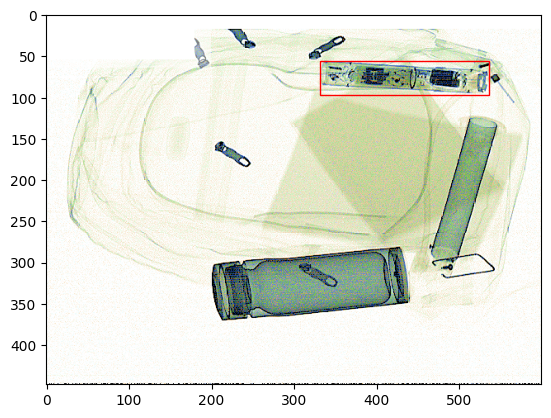

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import torchvision.transforms.functional as F
from PIL import Image, ImageDraw


def retrieve_image_data(idx):
  image = _images[idx]["file_name"]
  print("Image name:", image)

  cat_id = ann[idx]['category_id']
  print("Category ID:", cat_id)

  category = [x['name'] for x in categories if x['id'] == cat_id]
  print("Category:", category)

  image_path = os.path.join('/content/pidray/easy', image)
  print("Image path:", image_path)

  img = Image.open(image_path)
  print("Image size (W x H):", img.size)

  bbox = ann[idx]['bbox']
  print("Bounding box (x, y, w, h):", bbox)

  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(img)

  # Create a Rectangle patch
  rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

  plt.show()

retrieve_image_data(2)

In [9]:
class PidrayDataset(Dataset):
    def __init__(self, root_dir, images, annotations, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.images = images
        self.annotations = annotations
        self.target_transform = target_transform
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalise to stop model from flapping.
        ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.images[idx]['file_name']
        img_path = os.path.join(self.root_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        # we resize the image here to match the paper so need to do the same with the annotations
        old_width, old_height = img.size
        new_width, new_height = 500, 500

        width_scale = new_width / old_width
        height_scale = new_height / old_height

        bbox = self.annotations[idx]['bbox']
        bbox = [bbox[0]*width_scale, bbox[1]*height_scale,
                (bbox[0] + bbox[2])*width_scale,
                (bbox[1] + bbox[3])*height_scale]

        boxes = torch.as_tensor([bbox], dtype=torch.float32).squeeze(0)

        labels = torch.tensor([self.annotations[idx]['category_id']], dtype=torch.int64).squeeze(0)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        img = img.resize((new_width, new_height))  # resize the image

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            target = self.target_transform(target)

        return img, target

In [10]:
dataset = PidrayDataset(root_dir='/content/pidray/easy',
                        images=_images,
                        annotations=ann,
                        transform=torchvision.transforms.ToTensor())

[276.6095886230469, 61.5673942565918, 446.700927734375, 108.1977767944336]


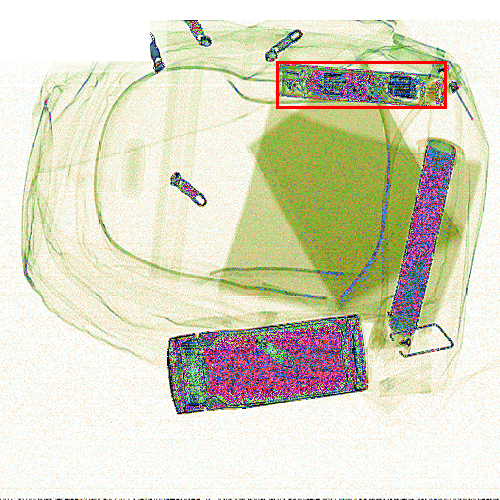

In [11]:
def draw_boxes(image, box):
    pil_image = F.to_pil_image(image).convert("RGB")
    draw = ImageDraw.Draw(pil_image)
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)
    return pil_image

sample_img, sample_target = dataset[2]
boxes = sample_target["boxes"].tolist()
print(boxes)


image_with_boxes = draw_boxes(sample_img, boxes)

# Display the image with boxes
display(image_with_boxes)


In [ ]:
# Create a list of indices from 0 to the length of the dataset
indices = list(range(len(dataset)))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

dataset_train = torch.utils.data.Subset(dataset, train_indices)
dataset_test = torch.utils.data.Subset(dataset, test_indices)

data_loader_train = DataLoader(dataset_train, batch_size=2, shuffle=True, num_workers=4)
data_loader_test = DataLoader(dataset_test, batch_size=2, shuffle=False, num_workers=4)

In [13]:
print(len(data_loader_train))
print(len(data_loader_test))

3793
949


In [14]:
for i, (images, labels) in enumerate(data_loader_train):
  print(labels)
  if i == 0:
    break
# batch of two so two bboxes here and two labels:

{'boxes': tensor([[137.9310, 246.8885, 203.5005, 310.1326],
        [ 83.1774, 296.0737, 156.9820, 411.1149]]), 'labels': tensor([12,  5])}


We take advantage of the resnet 50 layers model. Why reinvent the wheel to do a vision task! Specially if you think that resnet is pretrained on millions of images before you come to use it. - make ours lives much easier.

<br>
Below we tweak the final classifcation layer in the pretrained model to work with our number of classes.

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load a pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)

# Replace the classifier with a new one
num_classes = len(categories) + 1   # classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 3

for epoch in range(num_epochs):
    # Training
    model.train()
    i = 0
    epoch_loss = 0

    for images, targets in tqdm(data_loader_train):

        images = [image.to(device) for image in images]

        targets_res = []
        for i in range(len(targets['boxes'])):
            target = {}
            target['boxes'] = targets['boxes'][i].unsqueeze(0).to(device)
            target['labels'] = targets['labels'][i].unsqueeze(0).to(device)
            targets_res.append(target)
        loss_dict = model(images, targets_res)
        losses = sum(loss for loss in loss_dict.values())
        # print(f"{loss_dict}")
        # print(losses.item())

        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        i += 1

    # Update the learning rate
    lr_scheduler.step()

    # Print the final loss
    print(f"Epoch #{epoch} loss: {epoch_loss/i}")



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 3793/3793 [25:15<00:00,  2.50it/s]


Epoch #0 loss: 1064.2782864943147


100%|██████████| 3793/3793 [25:10<00:00,  2.51it/s]


Epoch #1 loss: 756.67068387568


100%|██████████| 3793/3793 [25:11<00:00,  2.51it/s]

Epoch #2 loss: 602.2036712169647


The losses above are a bit hard to measure because with object detection it measures the losses across, labels, bbox position etc. You can see the loss coming down though so would be useful to train for more epochs and more data if you have the time!

Predicted Label: HandCuffs


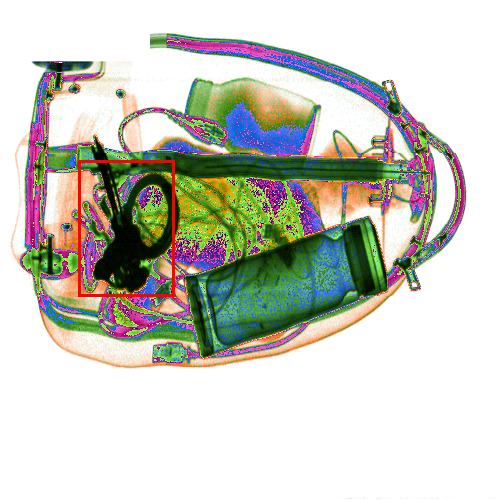



Predicted Label: Lighter


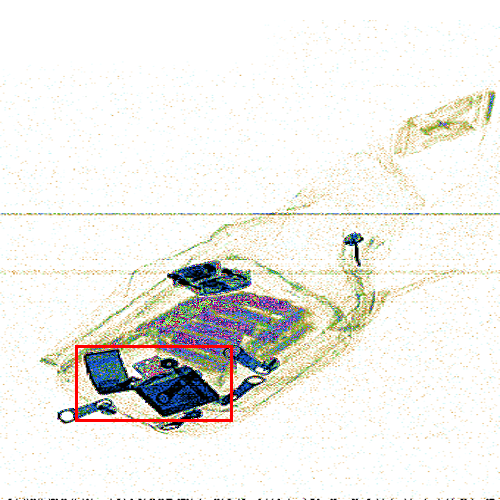



Predicted Label: Pliers


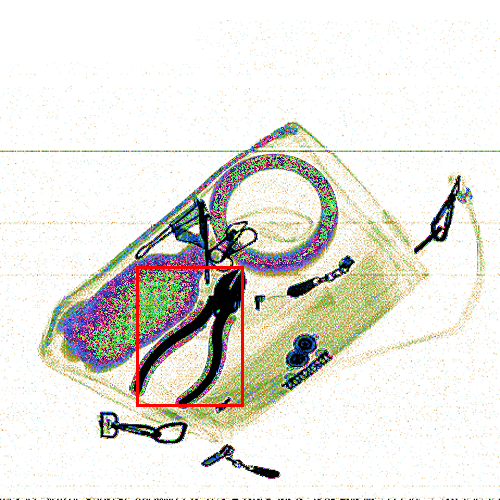



Predicted Label: Knife


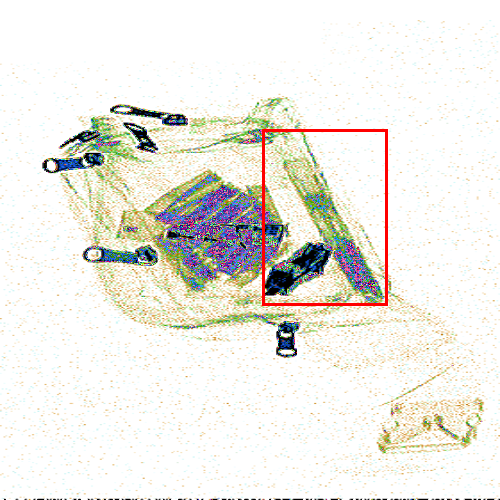

In [59]:
cat = {}

for x in categories:
  cat[x["id"]] = x["name"]

model.eval()

# Define the threshold
threshold = 0.5

# Iterate over the test data
for i, (images, _) in enumerate(data_loader_test):

    images = [image.to(device) for image in images]

    with torch.no_grad():
        predictions = model(images)

    for image, prediction in zip(images, predictions):
        # Move the image and prediction to cpu for numpy- (currently on gpu)
        image = image.cpu()
        prediction = {k: v.cpu() for k, v in prediction.items()}

        # The prediction is a dict, containing the predicted scores, labels and boxes
        scores = prediction['scores'].numpy()
        labels = prediction['labels'].numpy()
        boxes = prediction['boxes'].numpy()

        # Use a threshold to filter out low-confidence predictions
        selected_indices = np.where(scores > threshold)[0]
        selected_boxes = boxes[selected_indices]
        selected_labels = labels[selected_indices]
        selected_scores = scores[selected_indices]

        image = F.to_pil_image(image)

        # Draw bounding boxes on the image
        draw = ImageDraw.Draw(image)
        for box in selected_boxes:
            draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)

        for x in selected_labels:
          print("Predicted Label: "+cat[x])
        display(image)
        print("\n")

    # Stop after certain amount for demonstration purposes
    if i == 1:
      break
